# Tamm-Dancoff

The Tamm-Dancoff approximation (TDA) corresponds to setting $\mathbf{B}=\mathbf{0}$ in the electronic Hessian $\mathbf{E}^{[2]}$ and diagonalize only matrix block $\mathbf{A}$. This leads to some saving in computational cost, and typically has limited impact on the resulting spectra.

In [1]:
import py3Dmol as p3d
import veloxchem as vlx
import matplotlib.pyplot as plt
import numpy as np
from valet import transition_analysis_utils as tau

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


In [2]:
ethene_xyz = """6

C        0.67759997    0.00000000    0.00000000
C       -0.67759997    0.00000000    0.00000000
H        1.21655197    0.92414474    0.00000000
H        1.21655197   -0.92414474    0.00000000
H       -1.21655197   -0.92414474    0.00000000
H       -1.21655197    0.92414474    0.00000000
"""

In [9]:
molecule = vlx.Molecule.from_xyz_string(ethene_xyz)
basis = vlx.MolecularBasis.read(molecule, "STO-3G")

scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(molecule, basis)

lres_drv = vlx.LinearResponseEigenSolver()
rsp_settings = {"nstates": 12}
lres_drv.update_settings(rsp_settings)
lres_out = lres_drv.compute(molecule, basis, scf_results)

* Info * Reading basis set from file: /home/thomas/miniconda3/envs/echem/lib/python3.10/site-packages/veloxchem/basis/STO-3G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: STO-3G                                                                              
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
              

In [4]:
mo_energy = scf_results["E_alpha"]
nocc = molecule.number_of_alpha_electrons()
norb = mo_energy.shape[0]
nvirt = norb - nocc

In [5]:
lres_drv = vlx.LinearResponseEigenSolver()
E2 = lres_drv.get_e2(molecule, basis, scf_results)

n = nocc * nvirt
print("Dimension of full Hessian:", 2 * n)

S2 = np.identity(2 * n)
S2[n:, n:] *= -1

lrs_drv = vlx.LinearResponseSolver()

mu_x = lrs_drv.get_prop_grad("electric dipole", "x", molecule, basis, scf_results)[0]
mu_y = lrs_drv.get_prop_grad("electric dipole", "y", molecule, basis, scf_results)[0]
mu_z = lrs_drv.get_prop_grad("electric dipole", "z", molecule, basis, scf_results)[0]

V1x = -mu_x
V1y = -mu_y
V1z = -mu_z

print("Dimension of V[1] vectors:", V1x.shape[0])

* Info * Processing Fock builds... (batch size: 192)                                                                      
* Info *   batch 1/1                                                                                                      
Dimension of full Hessian: 96
Dimension of V[1] vectors: 96


In [10]:
eigs, X = np.linalg.eig(np.matmul(np.linalg.inv(S2), E2))

# Reorder results
idx = np.argsort(eigs)
eigs = np.array(eigs)[idx]
X = np.array(X)[:, idx]
# print first 12 positive eigenvalues:
print(eigs[n : n + 12])

# print(f'Excitation energy (au): {eigs[idx] : .6f}')
print("Reference:\n", lres_out["eigenvalues"])

[0.36852357 0.39582117 0.41914496 0.53648534 0.59799821 0.66561384
 0.694277   0.75545073 0.79173677 0.82446474 0.8364707  0.83957699]
Reference:
 [0.36852357 0.39582117 0.41914496 0.53648534 0.59799821 0.66561384
 0.694277   0.75545073 0.79173677 0.82446474 0.8364707  0.83957699]


In [11]:

eigs_tda, X_tda = np.linalg.eig(np.matmul(np.linalg.inv(S2[:n, :n]), E2[:n, :n]))
idx = np.argsort(eigs_tda)
eigs_tda = np.array(eigs_tda)[idx]
X_tda = np.array(X_tda)[:, idx]
# print first 12 eigenvalues:
print(eigs_tda[:12])
print("\nFull space:\n", eigs[n : n + 12])

[0.39915917 0.40168018 0.41930052 0.53735899 0.59809649 0.66604468
 0.69555511 0.75686368 0.79771708 0.82477564 0.84016783 0.84277658]

Full space:
 [0.36852357 0.39582117 0.41914496 0.53648534 0.59799821 0.66561384
 0.694277   0.75545073 0.79173677 0.82446474 0.8364707  0.83957699]


We can also use the `TDAExciDriver`:

In [12]:
tda_drv = vlx.TDAExciDriver()
tda_drv.update_settings(rsp_settings)
tda_results = tda_drv.compute(molecule, basis, scf_results)

                                                                                                                          
                                                     TDA Driver Setup                                                     
                                                                                                                          
                               Number of States                : 12                                                       
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Scheme            : Cauchy Schwarz + Density                                 
                               ERI Screening Threshold         : 1.0e-12                                                  
                

Plotting the results as bar spectra and comparing to full-space results:

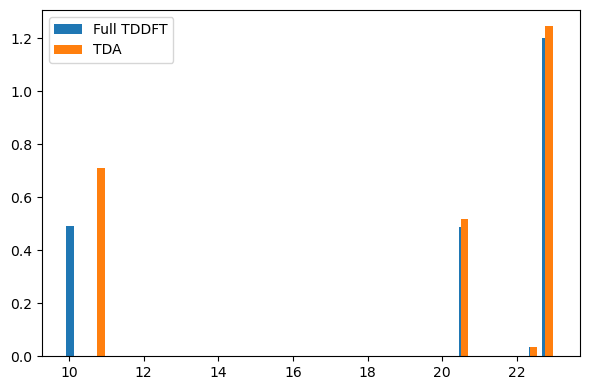

In [13]:
plt.figure(figsize=(6, 4))
x = 27.2114 * lres_out["eigenvalues"]
y = lres_out["oscillator_strengths"]
plt.bar(x, y, width=0.2)
x = 27.2114 * tda_results["eigenvalues"]
y = tda_results["oscillator_strengths"]
plt.bar(x, y, width=0.2)
plt.legend(("Full TDDFT", "TDA"))
plt.tight_layout()
plt.show()